#Project Description
At Boston University, Fitrec is a hotspot among students. As the only gym in BU's main campus, it is crowded often, making it insufficient for students to get a proper workout. Therefore, our project aims to analyze how different elements such as weather, time of day, and time of semester (e.g: first week of classes, midterm season, finals season, etc) affect people going to Fitrec. Using this information, we also plan to ultimately predict what’s the best time and day to visit the Fitrec.

# Libraries

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import os
import numpy as np

#Reading Data

In [3]:
data = pd.read_csv("data.csv")
data.head()

,Timestamp,What year are you?,How frequently do you visit Fitrec on a weekly basis?,Which days do you work out regularly?,Which timeslot do you work out the most in?,"On a scale of 1 - 5, how would would rank the crowdedness at the gym in your selected timeslot? (1 being really empty with no wait time, and 5 being running a 6 person work-in session.)","Does weather, such as rain or snow, ever influence your decision to skip the gym on certain days?","Do exams (midterms, finals) or projects affect the frequency of your gym visits?","If you said yes to the previous question, which month(s) would you say you visit the gym less than regular?","Do you use the Fitrec during holidays such as Thanksgiving, Indigineous Peoples Day?"
0,10/24/2024 22:28:46,Senior,3 - 5 times,"Monday, Tuesday, Wednesday, Thursday, Sunday",6 PM to 9 PM,4.0,yes,yes,"October, December",no
1,10/24/2024 22:29:01,Senior,3 - 5 times,"Monday, Tuesday, Saturday",6 PM to 9 PM,4.0,yes,yes,"October, December",no
2,10/24/2024 22:31:49,Senior,0 - 2 times,"Saturday, Sunday",9 PM to 11 PM,3.0,yes,yes,October,no
3,10/24/2024 22:41:51,Senior,0 - 2 times,"Monday, Wednesday",6 AM to 9 AM,2.0,yes,yes,October,yes
4,10/24/2024 22:45:47,Junior,3 - 5 times,"Monday, Tuesday, Wednesday, Thursday, Friday",3 PM to 6 PM,3.0,no,yes,"November, December",yes


#Data Preprocessing

In [4]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')

# Convert crowdedness to numeric
data['Crowdedness'] = pd.to_numeric(
    data['On a scale of 1 - 5, how would would rank the crowdedness at the gym in your selected timeslot? (1 being really empty with no wait time, and 5 being running a 6 person work-in session.) '],
    errors='coerce'
)

# Encoding categorical variables
data['Year'] = data['What year are you?'].astype('category').cat.codes
data['Weekly_Frequency'] = data['How frequently do you visit Fitrec on a weekly basis?'].map({
    '0 - 2 times': 1, '3 - 5 times': 2, 'More than 5 times': 3
})

# Feature Engineering: Extracting hour and day of the week from timestamp
data['Hour'] = data['Timestamp'].dt.hour
data['Day_of_Week'] = data['Timestamp'].dt.dayofweek
data['Timeslots'] = data['Which timeslot do you work out the most in?']
data['Days'] = data['Which days do you work out regularly?']
data['Months'] = data['If you said yes to the previous question, which month(s) would you say you visit the gym less than regular?']

# Prepare the feature set and target variable
X = data[['Year', 'Weekly_Frequency', 'Hour', 'Day_of_Week']]
y = data['Crowdedness'].fillna(data['Crowdedness'].median())


print("X shape:", X.shape)
print("y shape:", y.shape)
print()

X shape: (101, 4)
y shape: (101,)



#Visualizations

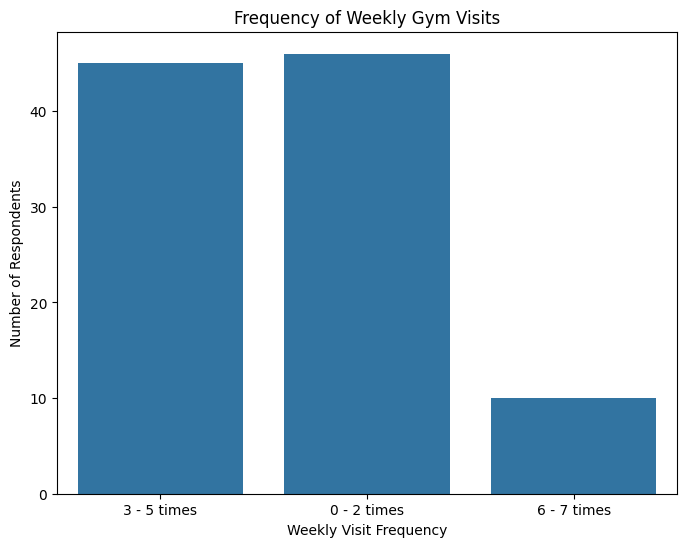

In [5]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='How frequently do you visit Fitrec on a weekly basis?')
plt.title('Frequency of Weekly Gym Visits')
plt.xlabel('Weekly Visit Frequency')
plt.ylabel('Number of Respondents')
plt.show()

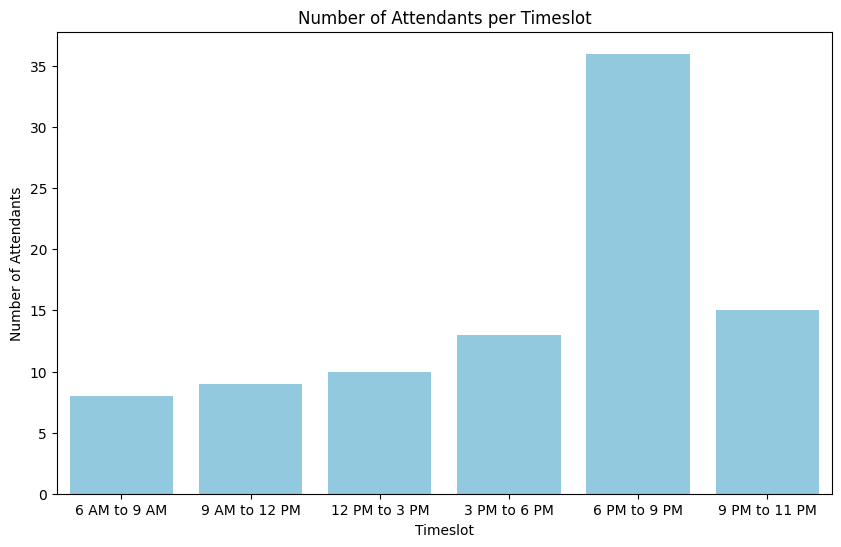

In [6]:
timeslot_counts = data['Timeslots'].value_counts().reindex(["6 AM to 9 AM", "9 AM to 12 PM", "12 PM to 3 PM",
                                                            "3 PM to 6 PM", "6 PM to 9 PM", "9 PM to 11 PM"])

# Plotting the number of respondents per timeslot
plt.figure(figsize=(10, 6))
sns.barplot(x=timeslot_counts.index, y=timeslot_counts.values, color="skyblue")
plt.title('Number of Attendants per Timeslot')
plt.xlabel('Timeslot')
plt.ylabel('Number of Attendants')
plt.show()

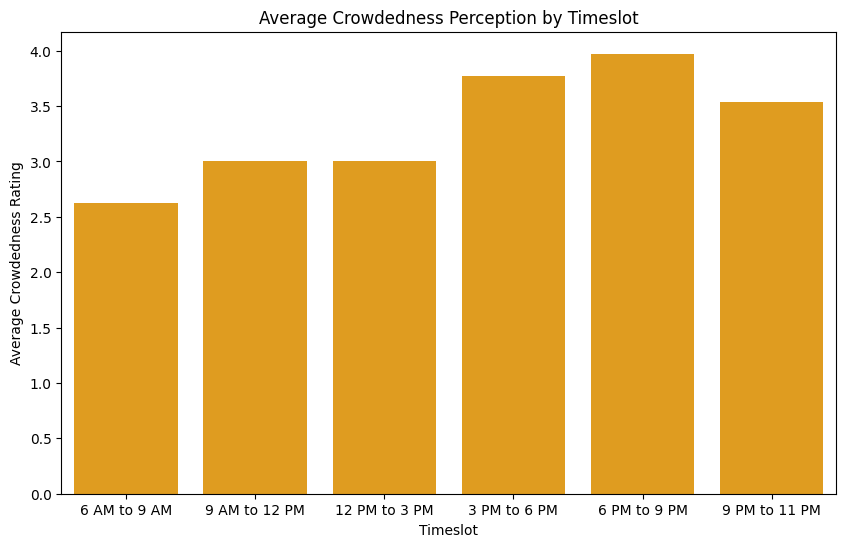

In [7]:
timeslot_order = ["6 AM to 9 AM", "9 AM to 12 PM", "12 PM to 3 PM", "3 PM to 6 PM", "6 PM to 9 PM", "9 PM to 11 PM"]
average_crowdedness_by_timeslot = data.groupby('Timeslots')['Crowdedness'].mean().reindex(timeslot_order)

# Creating a bar plot to visualize the average crowdedness by timeslot
plt.figure(figsize=(10, 6))
sns.barplot(x=average_crowdedness_by_timeslot.index, y=average_crowdedness_by_timeslot.values, order=timeslot_order, color = 'orange')
plt.title('Average Crowdedness Perception by Timeslot')
plt.xlabel('Timeslot')
plt.ylabel('Average Crowdedness Rating')
plt.show()

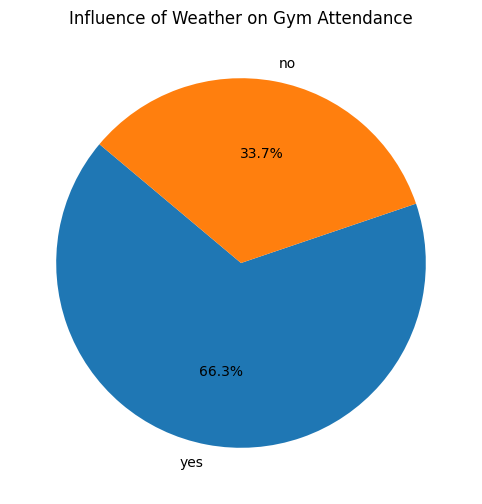

In [8]:
# Weather Influence on Gym Attendance
plt.figure(figsize=(8, 6))
weather_counts = data['Does weather, such as rain or snow, ever influence your decision to skip the gym on certain days?'].value_counts()
plt.pie(weather_counts, labels=weather_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Influence of Weather on Gym Attendance')
plt.show()

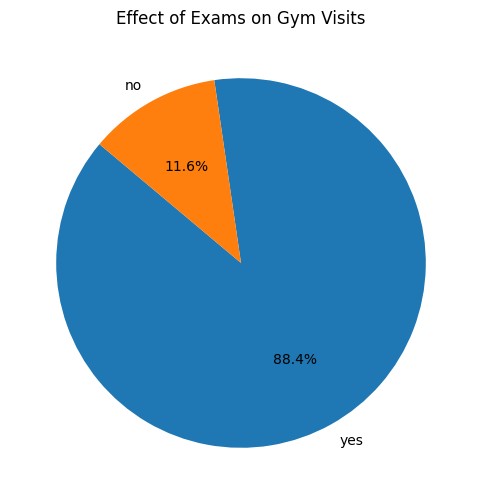

In [9]:
# Effect of Exams on Gym Visits
plt.figure(figsize=(8, 6))
exam_counts = data['Do exams (midterms, finals) or projects affect the frequency of your gym visits?'].value_counts()
plt.pie(exam_counts, labels=exam_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Effect of Exams on Gym Visits')
plt.show()

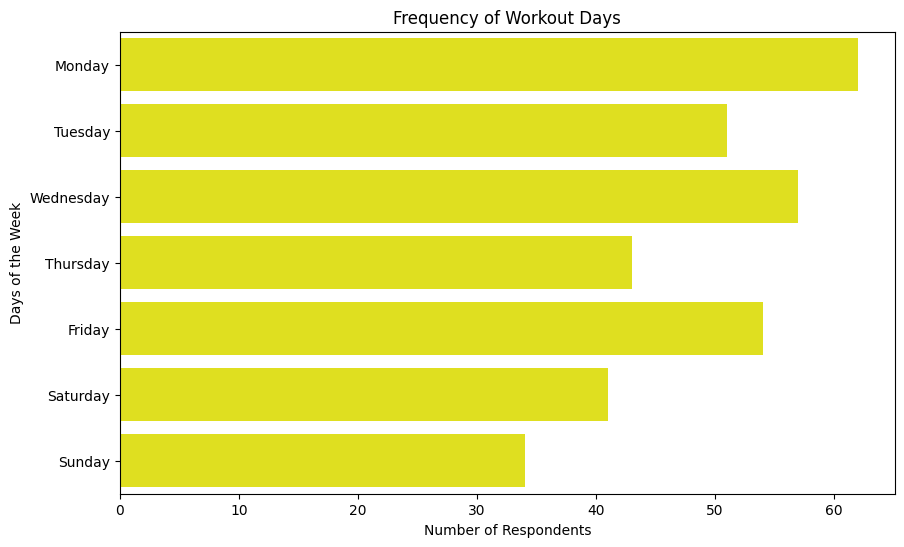

In [10]:

# Ensure the 'Days' column exists and split it if respondents could select multiple days
data['Days'] = data['Days'].str.split(', ')

# Explode the 'Days' column to count each selected day separately
day_counts = data.explode('Days')['Days'].value_counts()

# Define the correct day order
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Reindex the counts to the custom day order
day_counts = day_counts.reindex(day_order).fillna(0)  # Fill any missing days with 0

# Plotting the frequency of workout days in the correct order
plt.figure(figsize=(10, 6))
sns.barplot(x=day_counts.values, y=day_counts.index, order=day_order, color = 'yellow')
plt.title('Frequency of Workout Days')
plt.xlabel('Number of Respondents')
plt.ylabel('Days of the Week')
plt.show()



In [25]:
#Define crowdedness threshold for binary classification (e.g., "High" = 4 or above, "Low" = below 4)
data['Crowdedness_Binary'] = data['Crowdedness'].apply(lambda x: 1 if x >= 4 else 0)

# Encoding other categorical variables for logistic regression
timeslot_mapping = {
    "6 AM to 9 AM": 1,
    "9 AM to 12 PM": 2,
    "12 PM to 3 PM": 3,
    "3 PM to 6 PM": 4,
    "6 PM to 9 PM": 5,
    "9 PM to 11 PM": 6
}
data['Timeslot_Num'] = data['Which timeslot do you work out the most in?'].map(timeslot_mapping)
data['Year'] = data['What year are you?'].astype('category').cat.codes
data['Weekly_Frequency'] = data['How frequently do you visit Fitrec on a weekly basis?'].map({
    '0 - 2 times': 1, '3 - 5 times': 2, 'More than 5 times': 3
})

# Extract features for logistic regression
X = data[['Year', 'Weekly_Frequency', 'Hour', 'Day_of_Week', 'Timeslot_Num']]
y = data['Crowdedness_Binary'].fillna(data['Crowdedness'].median())

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.25, random_state=42)

# Train the logistic regression model
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Logistic Regression - Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Optional: Predict crowdedness for a new input (e.g., Thursday, 9 AM to 12 PM)
new_input = [[0, 2, 9, 3, 2]]  # Sample input for new data point (Year, Weekly_Frequency, Hour, Day_of_Week, Timeslot_Num)
new_prediction = logistic_model.predict(new_input)
print("Predicted Crowdedness Level (1 = High, 0 = Low):", new_prediction[0])


Logistic Regression - Accuracy: 0.54
Precision: 0.50
Recall: 0.50
F1 Score: 0.50
Predicted Crowdedness Level (1 = High, 0 = Low): 0


In [30]:
X = imputer.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Use a Random Forest Regressor model to predict crowdedness levels
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate model performance
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

# Use the model to predict crowdedness across all combinations of days and timeslots
timeslots = list(timeslot_mapping.values())
days_of_week = list(range(7))  # 0 = Monday, 6 = Sunday

# Creating a DataFrame to store predictions for each day and timeslot
predictions = []
for day in days_of_week:
    for timeslot in timeslots:
        sample = [[0, 2, 12, day, timeslot]]  # Sample values for non-time factors
        pred_crowdedness = model.predict(sample)
        predictions.append((day, timeslot, pred_crowdedness[0]))

# Convert predictions to DataFrame for easier analysis
pred_df = pd.DataFrame(predictions, columns=['Day_of_Week', 'Timeslot_Num', 'Predicted_Crowdedness'])

# Map back to day names and timeslot labels
day_mapping = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}
pred_df['Day'] = pred_df['Day_of_Week'].map(day_mapping)
pred_df['Timeslot'] = pred_df['Timeslot_Num'].map({v: k for k, v in timeslot_mapping.items()})

# Find the day and timeslot with the lowest predicted crowdedness
optimal_times = pred_df.sort_values(by='Predicted_Crowdedness').head()
print("Optimal Days and Times to Visit the Gym:")
print(optimal_times[['Day', 'Timeslot', 'Predicted_Crowdedness']])

Mean Squared Error: 0.80
Optimal Days and Times to Visit the Gym:
         Day       Timeslot  Predicted_Crowdedness
18  Thursday   6 AM to 9 AM                   2.32
24    Friday   6 AM to 9 AM                   2.34
36    Sunday   6 AM to 9 AM                   2.37
30  Saturday   6 AM to 9 AM                   2.37
19  Thursday  9 AM to 12 PM                   2.68


In [31]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred_class = clf.predict(X_test)

# Calculate classification metrics
accuracy = accuracy_score(y_test, y_pred_class)
print(accuracy)



0.5
